# Equilibrium Selection for Multi-agent Reinforcement Learning: A Unified Framework

This work addresses the problem of equilibrium selection in multi-agent reinforcement learning (MARL). In this notebook we implement a unified framework for equilibrium selection in stochastic games. The framework is modular and adaptable, allowing established learning rules and selection results from normal-form games to be extended to the MARL setting.

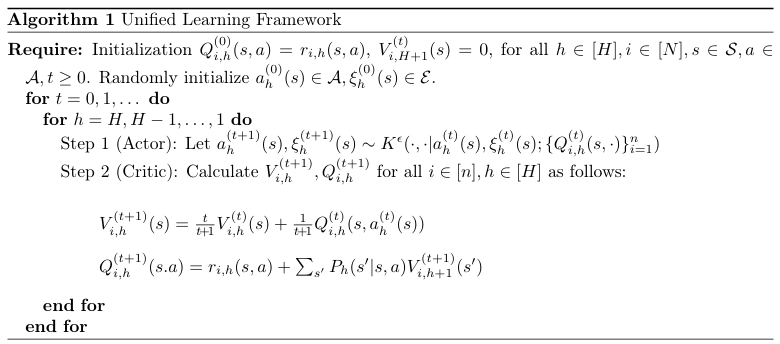

We apply this framework to two normal-form games with two players and two rewards $h = 1,2$, showing the convergence with two different learning rules.

## Learning Rules
For equilibrium selection, we assume that the group of agents follows certain iterative learning rules, which describe how they respond to the reward outcome from the previous action. In particular this is represented through a transition kernel $K^\epsilon$:
$$(a^{(t+1)}, \xi^{(t+1)}) \sim K^\epsilon(\cdot,\cdot \mid a^{(t)},\xi^{(t)}),$$
      
where $\xi \in \mathcal{E}$ are auxiliary variables, that depend on the rule, and $\epsilon \in (0,1)$ is a parameter that represents the ‘rate of mistakes’, assuming that agents does not respond in a fully rational and accurate way towards their observation of the reward outcome (rationality comes when $\epsilon \rightarrow 0$). 
     

### Log-linear Learning Rule
No hidden variable: $\mathcal{E} = \emptyset$. 

Updating rule:
$$K^\epsilon \left(a^{(t+1)} = (a_{-i}^{(t)},a_{i}^{(t+1)})\mid a^{(t)} ; \{r_i\}_{i=1}^n \right) = \frac{1}{n} \frac{\epsilon^{-r_i(a^{(t+1)})}}{\sum_{a'_i}{\epsilon^{-r_i(a'_i,a_{-i}^{(t)})}}}$$

### Marden Mood Learning Rule
Hidden variable: $\xi = (\xi_1, \dots, \xi_n)$, where $\xi_i \in \{C,D\}$ represents the mood of agent *i* (C stands for Content, D for Discontent). 

Updating rule:

*Action dynamics:*
$\begin{cases}
        \text{if} \; \xi_i^{(t)} = D \rightarrow a_i^{(t+1)} \sim \text{Unif}(\mathcal{A}_i) \\
        \\
        \text{if} \; \xi_i^{(t)} = C \rightarrow a_i^{(t+1)} \begin{cases}
            = a_i^{(t)} \quad\text{with prob} \; 1 - \epsilon^c\\
            \sim \text{Unif}(\mathcal{A}_i\backslash \{a_i^{(t)}\}) \quad\text{with prob} \; \epsilon^c
        \end{cases}
    \end{cases} $

<br>

*Mood dynamics:*
$\begin{cases}
        \text{if} \; \xi_i^{(t)} = C \text{ and } a_i^{(t+1)} = a_i^{(t)} \rightarrow \xi_i^{(t+1)} = C \\
        \\
        \text{else} \rightarrow \xi_i^{(t+1)} = \begin{cases}
            C \quad\text{with prob} \; \epsilon^{1-r_i(a^{(t+1)})}\\
            D \quad\text{otherwise}
        \end{cases}
    \end{cases} $

**Notice:** In the case of the Marden Mood learning rule, the term $\epsilon^{1-r_i(a^{(t+1)})}$ must be a valid probability. For this reason, the implementation takes care of the rewards normalisation. On the contrary, the Log-linear learning rule employs a softmax update, which inherently normalizes the rewards; applying normalization beforehand would result in an additional compression of the value range.

## Games

### Treasure Game

This identical interest game captures the process of two players collaboratively digging treasure at two different locations 0 and 1. Each location has a shallow level and a deep level, and it requires the players to collaboratively dig at the same location to make progress. 

- Location 0 has reward 1 at the shallow level and 0.5 at the deep level. 
- Location 1 has reward 0 at the shallow level and 2 at the deep level. 

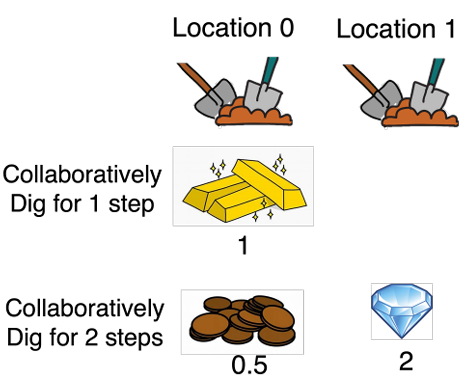

The process can be summarized as a stochastic game. For h = 1, there’s only one state and thus the stage reward is given by a 2 by 2 reward matrix with nonzero reward of value 1 only when a = (0,0). The transition to the second stage follows the following transition rule: 
- if both players 1 and 2 choose to dig at location 0 ($a_1 = a_2 = 0$), then the game will transit to state $s = A$, where they can arrive at the deep level for location 0 and shallow level at location 1;
- if $a_1 = a_2 = 1$ then the game will transit to $s = B$, where they can arrive at the deep level for location 1 and shallow level at location 0;
- if the players fail to agree on a location, ($a = (0,1) or (1,0)$), they make no progress ($s = O$) and the reward will remain the same as stage $h = 1$.

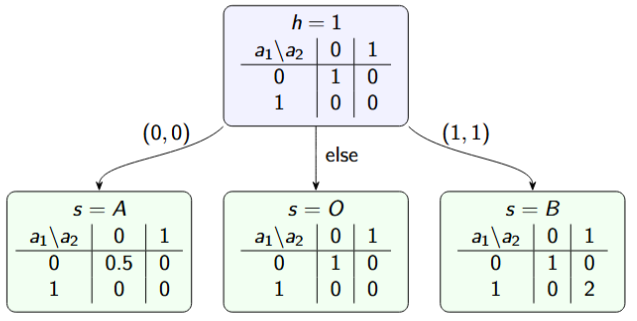

In this game, there are two strict NEs:
1. agreeing twice on location 0, i.e. $a_{i,h} = 0$ for $h = 1,2$ and $i = 1,2$; 
2. agreeing twice on location 1, i.e. $a_{i,h} = 1$ for $h = 1,2$ and $i = 1,2$. 

Notice that the second NE is also the global optimal policy that gives a total reward 2, while the first only gives reward 1.5. 

We are going to show that for log-linear learning, the stochastically stable policy is the global optimal policy, thus it should converge to the second instead of the first NE.

### Stag Hunt game

This coordination game models the process of two players choosing whether to hunt a stag or a hare over two stages. Hunting the stag is harder, and thus requires both players to fully cooperate and to keep hunting persistently for two stages to success, but it has a high reward (7.5 allocated evenly to both players). Hunting the hare instead is easier and can be done individually with one stage, but also with lower payoff: the value is 2, eventually to be split if both players decide to catch the hare.

The process can be summarized as a stochastic game:

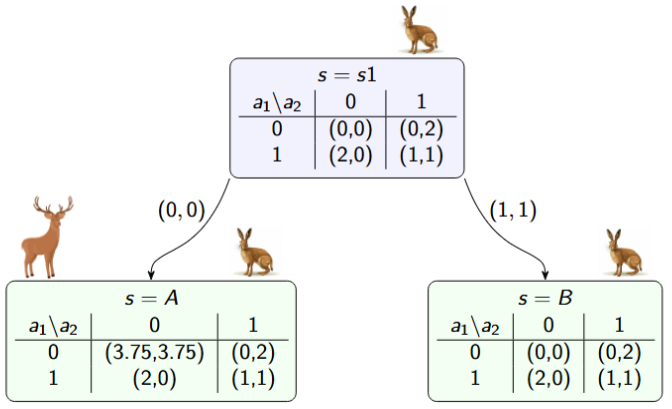

In this game, there are two strict Nash equilibria:

1. Stag NE: both players choose Stag at both stages ($a_{i,h} = 0$ for $h = 1,2$ and $i = 1,2$), yielding the Pareto-dominant outcome with total reward 7.5.
2. Hare NE: both players choose Hare at both stages ($a_{i,h} = 1$ for $h = 1,2$ and $i = 1,2$), yielding the risk-dominant outcome with total reward 2.

While the Stag equilibrium gives the higher social welfare, the Hare equilibrium is risk-dominant. We are going to show that running log-linear learning in this setting leads to convergence to the Hare equilibrium, while the Marden Mood learning rule favors the Pareto-optimal Stag equilibrium.


## Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm import tqdm
import copy
import numbers

In [6]:
# Games

class Game(ABC):
    "In this version, the structure only admits games with 2players and 2 stages and the transition function decribes only the passage from stage 1 to stage 2"
    def __init__(self):
        self.N = 2                      # number of players
        self.H = 2                      # horizon (number of stages)
        self.actions = None             # list of actions (in this version assumed to be the same for both players)
        self.rewards = {1: {}, 2: {}}   # dictionary with rewards np.array for each state in each stage
        self.s_map = {1: {}, 2: {}}     # dictionary with indices for each state in each stage

        self._build()

    @abstractmethod
    def _build(self):
        pass

    @abstractmethod
    def transition(self, a1, a2):
        """ Determines the state of stage 2 based on the action taken in stage 1 """
        pass


class TreasureGame(Game):

    def _build(self):
        self.N = 2      # players number
        self.H = 2      # horizon

        # actions (same for each player)
        self.actions = [0,1]

        # unnormalised rewards tables for each state
        self.rewards = {
            1: {'s1': np.array([[(1.0, 1.0), (0.0,0.0)],
                                [(0.0, 0.0), (0.0,0.0)]]) },
            2: {'A': np.array([[(0.5,0.5), (0.0,0.0)],
                           [(0.0,0.0), (0.0,0.0)]]),

            'B': np.array([[(1.0,1.0), (0.0,0.0)],
                           [(0.0,0.0), (2.0,2.0)]]),

            'O': np.array([[(1.0,1.0), (0.0,0.0)],
                           [(0.0,0.0), (0.0,0.0)]]) }
        }

        # indices of states per stage
        self.s_map = {
            1: {'s1': 0},
            2: {'A': 0, 'B': 1, 'O': 2}
        }

    def transition(self, a1, a2):
        if a1 == 0 and a2 == 0:
            return 'A'
        if a1 == 1 and a2 == 1:
            return 'B'
        return 'O'


class StagHuntGame(Game):

    def _build(self):
        self.N = 2      # players number
        self.H = 2      # horizon

        # actions (same for each player)
        self.actions = [0,1]

        # unnormalised rewards tables for each state
        self.rewards = {
            1: {'s1': np.array([[(0, 0), (0, 2)], 
                                [(2, 0), (1, 1)]]) },

            2: {'A': np.array([[(3.75, 3.75), (0, 2)],
                            [(2, 0), (1, 1)]]),

                'B': np.array([[(0, 0), (0, 2)],
                           [(2, 0), (1, 1)]]) }
        }

        # indices of states per stage
        self.s_map = {
            1: {'s1': 0},
            2: {'A': 0, 'B': 1}
        }
        

    def transition(self, a1, a2):
        """ Determines the state of stage 2 based on the action taken in stage 1 """
        if a1 == 0 and a2 == 0:
            return 'A'
        return 'B'


In [4]:
# Learning Rules

class LearningRule(ABC):
    """
    Base class for a learning rule, determines the framework that actual learning rules have to follow.
    """
    @abstractmethod
    def update_vars(self,current_action, current_hidden, num_players, actions, q_vals):
        """
        Determines the new actions for the agents.

        Args:
            current_action (list): current joint action [a1, a2].
            current_hidden (list): current joint hidden vars [xi_1, xi_2].
            num_players (int): number of agents.
            actions (list): possible actions for the agents to play (we assume they are the same for all agents).
            q_vals (list): Q-values for the possible actions of the agents.

        Returns:
            list, list: new action and new auxiliary variable.
        """
        pass

class LogLinearRule(LearningRule):
    """
    Implements the Log-Linear learning rule, which correspond to a softmax dependent from the param beta.
    Hidden variables are not necessary, the function returns the initialised value.
    Parameter: epsilon in (0,1)
    """
    def __init__(self, epsilon):
        if (epsilon <= 0) or (epsilon >=1):
            raise ValueError("The parameter epsilon has to be in (0,1).")
        self.epsilon = epsilon
        self.norm_rewards = False

    def update_vars(self, current_action, current_hidden, num_players, actions, q_vals):
        player_to_update = np.random.randint(num_players)

        if (player_to_update == 0):
            q_values_for_player = np.array(q_vals[player_to_update,:,current_action[1]])
        else:
            q_values_for_player = np.array(q_vals[player_to_update,current_action[0],:])

        unnorm_probs = pow(self.epsilon, -q_values_for_player)
        new_action_probs = unnorm_probs / (unnorm_probs.sum())
        
        new_action_for_player = np.random.choice(actions, p=new_action_probs)
        
        new_joint_action = list(current_action)
        new_joint_action[player_to_update] = new_action_for_player
        
        return new_joint_action, current_hidden
    
    
class MardenMoodRule(LearningRule):
    """
    Implements the Marden Mood learning rule.
    The hidden variables represent the internal mood of each agent: C (content) or D (discontent).
    Parameters: epsilon in (0,1), c >= num_players.
    """

    def __init__(self, epsilon, c, reward_prec:int=2):
        # self.beta = beta
        if (epsilon <= 0) or (epsilon >= 1):
            raise ValueError("The parameter epsilon has to be in (0,1).")
        self.epsilon = epsilon
        self.c = c
        self.norm_rewards = True
        self.reward_prec = reward_prec


    def update_vars(self,current_action, current_hidden, num_players, actions, q_vals):
        
        #Action update
        new_action = current_action[:]

        for i in range(num_players):
            if current_hidden[i]  == 'D':                       # discontent -> chooses randomly
                new_action[i] = np.random.choice(actions)

            else:                                               # content -> explores with a small probability
                prob_explore = pow(self.epsilon,self.c)

                if np.random.rand() < prob_explore:
                    other_actions = [a for a in actions if a != current_action[i]]
                    new_action[i] = np.random.choice(other_actions) if other_actions else current_action[i]     # choose a different action than the current if there are others
                else:
                    new_action[i] = current_action[i]
        
        #Mood update
        new_hidden = np.copy(current_hidden)

        for i in range(num_players):

            if (current_hidden[i] == 'C') and (current_action == new_action):   # content and action didn't change -> content
                new_hidden[i] = 'C'
            else:                                                               # else -> content with a higher prob. the higher is Q
                prob_content = pow(self.epsilon, 1 - q_vals[i][new_action[0]][new_action[1]])
                # print(f"Player {i}, prob to become C:", prob_content)

                if np.random.rand() < prob_content:
                    new_hidden[i] = 'C'
                else:
                    new_hidden[i] = 'D'

        return new_action, new_hidden

In [5]:
# Learning Algorithm

class UnifiedLearning:
    """
    Implements the algorithm Unified Learning Framework for a multi-agent game with finite horizon and two players.
    """
    def __init__(self, game, T, learning_rule):
        self.T = T          # number of learning iterations

        self.learning_rule = learning_rule

        if learning_rule.norm_rewards:
            self.game = self._normalize_rewards(game, learning_rule.reward_prec)
        else:
            self.game = game


        # Definition of variables

        # Q[player][stage h][state_index][action_pl1][action_pl2]
        self.Q = np.zeros((self.game.N, self.game.H + 1, len(self.game.s_map[2]), len(self.game.actions), len(self.game.actions)))

        # V[player][stage h][state_index]
        self.V = np.zeros((self.game.N, self.game.H + 2, len(self.game.s_map[2])))
        
        # a[stage h][state_index] -> (a1, a2)
        self.a = {}

        # xi[stage h][state_index] -> (xi_1, xi_2)
        self.hidden = {}

        # Save cronology of the state s1 to check convergence
        self.V_history = []             # V-value just of player 0 (we have symmetric games)
        self.s1_action_history = []     # pair of actions taken by both players

    def _normalize_rewards(self,game: Game, prec: int) -> Game:
        g = copy.deepcopy(game)
        
        max_val = 0.0
        for stage_data in g.rewards.values():
            for reward_matrix in stage_data.values():
                max_val = max(max_val, np.max(np.abs(reward_matrix)))

        if max_val == 0:
            return g  # nothing to normalize

        normalized = {}
        for stage, stage_data in g.rewards.items():
            normalized[stage] = {}
            for state, reward_matrix in stage_data.items():
                normalized[stage][state] = np.round(reward_matrix / max_val,prec)
        g.rewards = normalized

        return g

    def _initialize(self):
        """ Initialisation of Q-values, actions and hidden variables. """
        
        actions = self.game.actions

        # Q values are initialised to rewards
        for h in range(1, self.game.H + 1):
            for s_str, reward_matrix in self.game.rewards[h].items():
                s_idx = self.game.s_map[h][s_str]
                for a1 in actions:
                    for a2 in actions:
                        reward = reward_matrix[a1, a2]

                        for i in range(self.game.N):
                            self.Q[i, h, s_idx, a1, a2] = reward[i]

        # Actions and hidden variables are initialised randomly
        for h in range(1, self.game.H + 1):
            self.a[h] = {}
            self.hidden[h] = {}
            for _, s_idx in self.game.s_map[h].items():

                a1_rand = np.random.choice(actions)
                a2_rand = np.random.choice(actions)
                self.a[h][s_idx] = [a1_rand, a2_rand]
                
                if isinstance(self.learning_rule, MardenMoodRule):
                    hidd1_rand = np.random.choice(['C','D'])
                    hidd2_rand = np.random.choice(['C','D'])
                    self.hidden[h][s_idx] = [hidd1_rand, hidd2_rand]
                else:
                    self.hidden[h][s_idx] = [0.0, 0.0]


    def run(self):
        """ Run of the main learning cycle. """
        self._initialize()

        for t in range(self.T):

            V_t = np.copy(self.V)
            self.V_history.append(V_t[0, 1, 0])

            for h in range(self.game.H, 0, -1):
                
                # Actor: computes new actions and new auxiliary variables for all the states in stage h, using Q^(t)
                new_action_h = {}   #a_h_t_plus
                new_hidden_h = {}

                for s_str, s_idx in self.game.s_map[h].items():
                    current_a = self.a[h][s_idx]
                    current_hid = self.hidden[h][s_idx]

                    q_vals = self.Q[:, h, s_idx, :, :]
                             
                    new_action_h[s_idx], new_hidden_h[s_idx] = self.learning_rule.update_vars(current_a, current_hid, self.game.N, self.game.actions, q_vals)


                # Critic: updates V_{i,h} and Q_{i,h} for all the states in stage h, based on the new actions
                for s_str, s_idx in self.game.s_map[h].items():
                                        
                    # V-values update
                    t_joint_action = self.a[h][s_idx] 
                    for i in range(self.game.N):
                        q_val_t = self.Q[i, h, s_idx, t_joint_action[0], t_joint_action[1]]
                        
                        # Calcola la media mobile
                        if t == 0:
                           self.V[i, h, s_idx] = q_val_t
                        else:
                           old_v = V_t[i, h, s_idx]
                           self.V[i, h, s_idx] = (t / (t + 1)) * old_v + (1 / (t + 1)) * q_val_t

                    # Q-values update
                    for i in range(self.game.N):
                        for a1 in self.game.actions:
                            for a2 in self.game.actions:
                                expected_V = 0
                                if h < self.game.H: # Per h=1, calcola il valore atteso da h=2
                                    next_s_str = self.game.transition(a1, a2)
                                    next_s_idx = self.game.s_map[h + 1][next_s_str]
                                    expected_V = self.V[i, h + 1, next_s_idx]
                                
                                reward = self.game.rewards[h][s_str][a1,a2]
                                self.Q[i, h, s_idx, a1, a2] = reward[i] + expected_V

                # Save variables new values
                self.a[h] = new_action_h  
                self.hidden[h] = new_hidden_h              
            
            # Save history of the initial state
            action_in_s1 = self.a[1][0]         # action taken in h=1, s_idx=0

            self.s1_action_history.append(action_in_s1)


    def print_results(self):
        """ For each stage and state, prints the final V-values and Q-values learnt by player 0, and the pair of actions learnt. """
        print("\n--- Learnt Values  (Player 0)---")
        for h in range(1, self.game.H + 1):
            print(f"\n--- Stage h={h} ---")
            for s_str, s_idx in self.game.s_map[h].items():
                print(f"  State '{s_str}':")
                print(f"    V-value: {self.V[0, h, s_idx]:.4f}")
                print("    Q-values:")
                q_matrix = self.Q[0, h, s_idx, :, :]
                print("         a2=0    a2=1")
                print(f"    a1=0 [{q_matrix[0,0]:.2f}]  [{q_matrix[0,1]:.2f}]")
                print(f"    a1=1 [{q_matrix[1,0]:.2f}]  [{q_matrix[1,1]:.2f}]")
                print(f"    Learnt joint action (Policy): {[int(x) for x in self.a[h][s_idx]]}")

    
    def plot_convergence(self):
        """ Plots the convergence trajectory of the V-value of the initial state. """
        plt.figure(figsize=(10, 6))
        plt.plot(self.V_history)
        plt.xlabel("Iteration (t)")
        plt.ylabel("V(s1)")
        plt.title("Convergence of the V-value in the initial state 's1'")
        plt.grid(True)
        plt.show()


    def plot_policy_evolution(self,history, params):
        """
        Plots the policy evolution (just of the pair of actions (0,0) and (1,1)) according to the runs in hystory_of_all_runs,
        computed with empirical mean and a confidence interval at 60%.

        Args:
            history (list): List of lists. Each sublist contains the hystory of tuples of actions taken on each run.
            params (list): contains the parameters of the learning rule used to compute the hystory,
                                    - log learning: params = [epsilon]
                                    - marden mood:  params = [epsilon, c]
        """
        runs = np.array(self._normalize_runs(history))
        num_runs = len(history)
        T = self.T

        freq_00 = np.zeros((num_runs, T))
        freq_11 = np.zeros((num_runs, T))
           
        for i in range(num_runs):
            count_00 = 0
            count_11 = 0
            
            for t in range(T):
                action = tuple(runs[i, t])
                if action == (0, 0):
                    count_00 += 1
                elif action == (1, 1):
                    count_11 += 1
                
                freq_00[i, t] = count_00 / (t + 1)
                freq_11[i, t] = count_11 / (t + 1)
                

        # Mean of frequences
        mean_freq_00 = np.mean(freq_00, axis=0)
        mean_freq_11 = np.mean(freq_11, axis=0)

        # CI of frequences from 20° to 80° percentile
        lower_bound_00 = np.percentile(freq_00, 20, axis=0)
        upper_bound_00 = np.percentile(freq_00, 80, axis=0)
        
        lower_bound_11 = np.percentile(freq_11, 20, axis=0)
        upper_bound_11 = np.percentile(freq_11, 80, axis=0)


        plt.figure(figsize=(12, 7))
        
        plt.plot(mean_freq_00, color='blue', label='Prob(a=(0,0) | s1)')
        plt.plot(mean_freq_11, color='orange', label='Prob(a=(1,1) | s1)')
        if num_runs>1:
            plt.fill_between(range(T), lower_bound_00, upper_bound_00, color='blue', alpha=0.2, 
                        label='CI 60% for (0,0)')
            plt.fill_between(range(T), lower_bound_11, upper_bound_11, color='orange', alpha=0.2,
                        label='CI 60% for (1,1)')
        
        if isinstance(params, float):
            eps = params
            plt.title(f"Evolution of policy in state s1, eps = {eps}")
        elif isinstance(params, tuple):
            eps, c = params
            plt.title(f"Evolution of policy in state s1, eps = {eps}, c = {c}")

        plt.xlabel("Iteration (t)")
        plt.ylabel("Empirical probability of actions")
        plt.ylim(0, 1)
        plt.xlim(0, T)
        plt.legend()
        plt.grid(True)
        plt.show()

    def _normalize_runs(self, history):
        """
        Accepts:
            - single trajectory: List[List]
            - list of trajectories: List[List[List]]
        Returns:
            List[List[List]]
        """
        if len(history) == 0:
            raise ValueError("Empty history.")

        if isinstance(history[0][0], (numbers.Number,str)):
            return [history]
        return history

    

## Experiments and Results
### Log- linear learning rule


--- Learnt Values  (Player 0)---

--- Stage h=1 ---
  State 's1':
    V-value: 2.2515
    Q-values:
         a2=0    a2=1
    a1=0 [3.65]  [1.00]
    a1=1 [3.00]  [2.00]
    Learnt joint action (Policy): [1, 1]

--- Stage h=2 ---
  State 'A':
    V-value: 3.6528
    Q-values:
         a2=0    a2=1
    a1=0 [3.75]  [0.00]
    a1=1 [2.00]  [1.00]
    Learnt joint action (Policy): [0, 0]
  State 'B':
    V-value: 1.0002
    Q-values:
         a2=0    a2=1
    a1=0 [0.00]  [0.00]
    a1=1 [2.00]  [1.00]
    Learnt joint action (Policy): [1, 1]


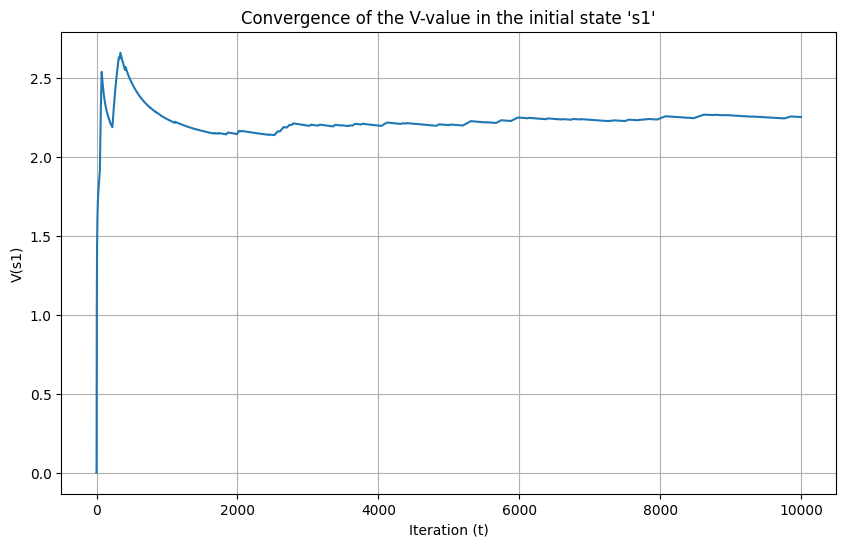

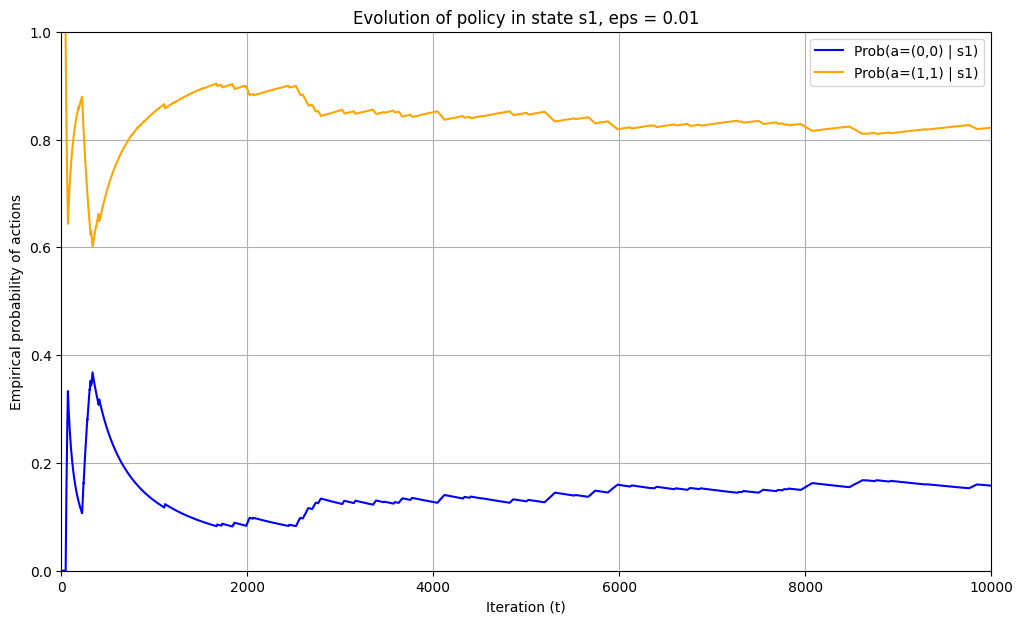

In [7]:
# PLOT A SINGLE TRAJECTORY OF LOG-LINEAR POLICY CONVERGENCE (referred to the initial state)
#---------------------------------------------

# Number of iterations to converge to the optimal policy
ITERATIONS = 10000

# Learning rule parameter
EPS = 0.01          # eps in (0,1), and policy converges to optimal if eps -> 0

# Choose what game to play:
# GAME = TreasureGame()
GAME = StagHuntGame()

learning_rule = LogLinearRule(epsilon=EPS)

learner = UnifiedLearning(game=GAME, T=ITERATIONS, learning_rule=learning_rule)
learner.run()

# Print the final V-values and Q-values learnt by player 0
learner.print_results()

# Plot the evolution of the V-value of player 0 in the initial state 
learner.plot_convergence()

# Plot the evolution of the policy in the initial state (just actions (0,0) and (1,1))
learner.plot_policy_evolution([learner.s1_action_history], params=EPS)

Starting 100 simulations...


Runs: 100%|██████████| 100/100 [01:20<00:00,  1.24run/s]


All simulations completed.
Generating policy plot...


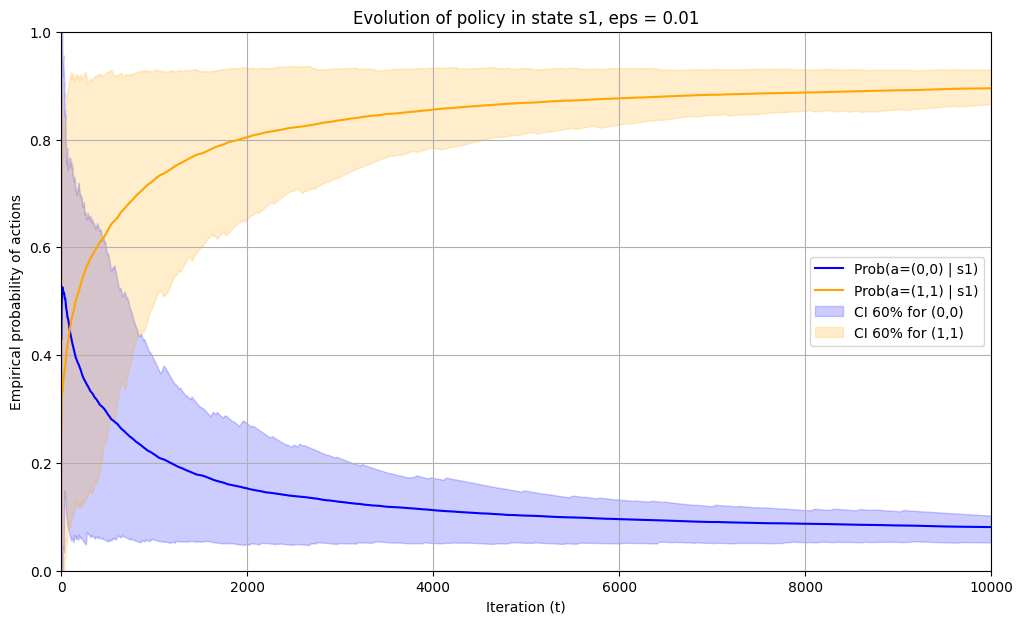

In [9]:
# PLOT LOG-LINEAR POLICY MEAN CONVERGENCE IN S1
# ------------------------

# Number of iterations to converge to the optimal policy
ITERATIONS = 10_000

# Number of trajectories used to compute the empirical mean and the variance of the policy, in order to plot convergence 
NUM_RUNS = 100

# List to collect the histories of actions taken in the initial state in all runs
all_runs_action_history = []

# Learning rule parameter
EPS = 0.01      # eps in (0,1), and policy converges to optimal if eps -> 0

# Run
print(f"Starting {NUM_RUNS} simulations...")
for i in tqdm(range(NUM_RUNS), desc="Runs", unit="run"):
    # Choose what game to play:
    # GAME = StagHuntGame()
    GAME = TreasureGame()
    
    learning_rule_to_use = LogLinearRule(epsilon=EPS)

    learner = UnifiedLearning(
        game=GAME, 
        T=ITERATIONS, 
        learning_rule=learning_rule_to_use
    )
    learner.run()
    
    # Save hystory of actions of this run
    all_runs_action_history.append(learner.s1_action_history)

print("All simulations completed.")

#Plot the policy evolution computed with empirical mean of actions (0,0) and (1,1) in the initial state
print("Generating policy plot...")
learner.plot_policy_evolution(history=all_runs_action_history, params=EPS)

### Marden Mood learning rule

Probability to explore when C:  0.0001

--- Learnt Values  (Player 0)---

--- Stage h=1 ---
  State 's1':
    V-value: 0.9935
    Q-values:
         a2=0    a2=1
    a1=0 [1.00]  [0.26]
    a1=1 [0.79]  [0.53]
    Learnt joint action (Policy): [0, 0]

--- Stage h=2 ---
  State 'A':
    V-value: 1.0000
    Q-values:
         a2=0    a2=1
    a1=0 [1.00]  [0.00]
    a1=1 [0.53]  [0.27]
    Learnt joint action (Policy): [0, 0]
  State 'B':
    V-value: 0.2581
    Q-values:
         a2=0    a2=1
    a1=0 [0.00]  [0.00]
    a1=1 [0.53]  [0.27]
    Learnt joint action (Policy): [1, 1]


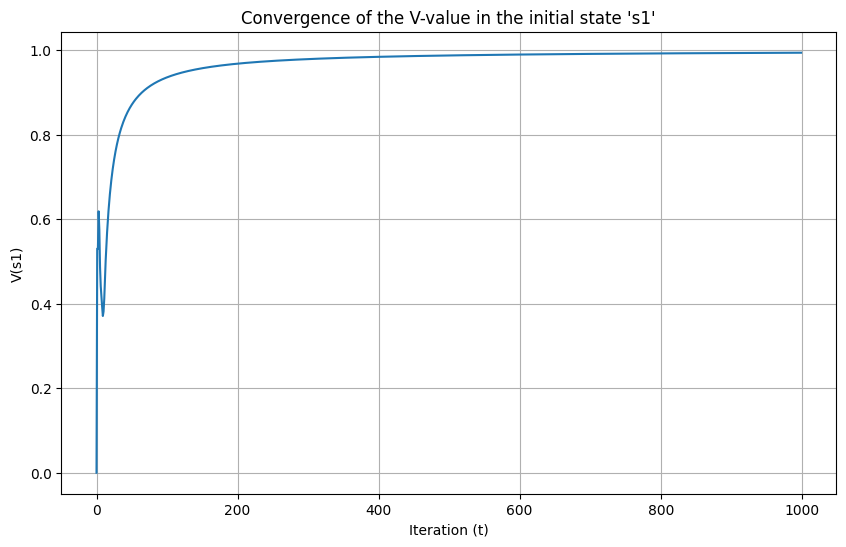

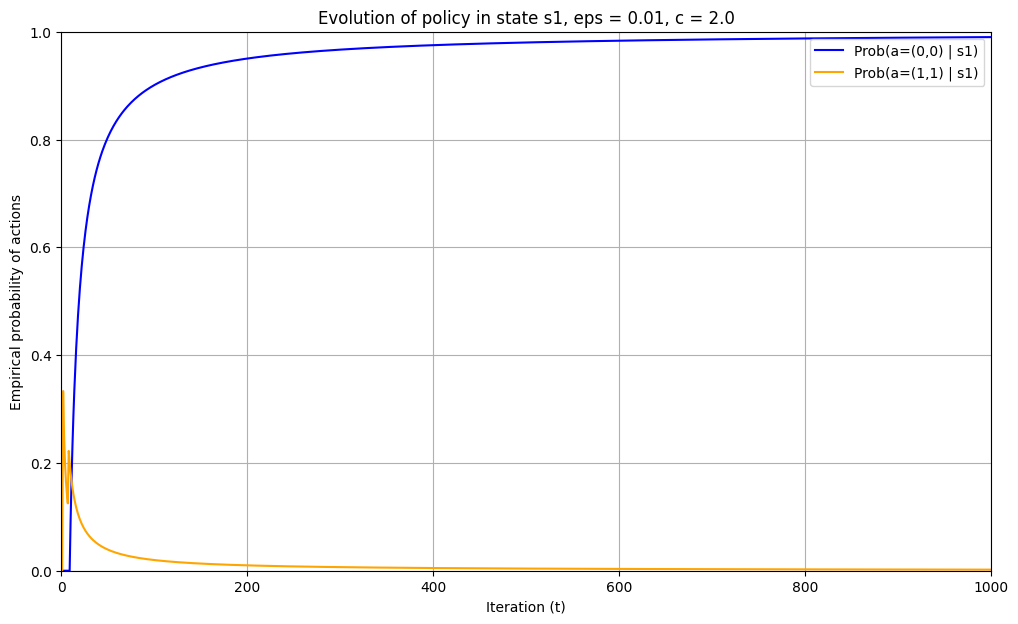

In [17]:
# PLOT A SINGLE TRAJECTORY OF MARDEN MOOD POLICY CONVERGENCE (referred to the initial state)
#---------------------------------------------

# Number of iterations to converge to the optimal policy
ITERATIONS = 1_000

# Learning rule parameters
C_PARAM = 2.0       # c >= n (n=2)
EPS = 0.01          # eps in (0,1), and policy converges to optimal if eps -> 0

print("Probability to explore when C: ", pow(EPS,C_PARAM))


GAME = StagHuntGame()

learning_rule = MardenMoodRule(epsilon=EPS, c=C_PARAM)

learner = UnifiedLearning(game=GAME, T=ITERATIONS, learning_rule=learning_rule)
learner.run()

# Print the final V-values and Q-values learnt by player 0
learner.print_results()

# Plot the evolution of the V-value of player 0 in the initial state 
learner.plot_convergence()

# Plot the evolution of the policy in the initial state (just actions (0,0) and (1,1))
learner.plot_policy_evolution([learner.s1_action_history], params=(EPS,C_PARAM))

In [ ]:
# MARDEN MOOD POLICY IN S1
# ------------------------

# Number of iterations to converge to the optimal policy
ITERATIONS = 1_000_000

# Number of trajectories used to compute the empirical mean and the variance of the policy, in order to plot convergence 
NUM_RUNS = 100

# List to collect the histories of actions taken in the initial state in all runs
all_runs_action_history = []

# Learning rule parameters
EPS = 0.01          # eps in (0,1), and policy converges to optimal if eps -> 0
C_PARAM = 2.0       # c >= n (n=2)

print("Probability to explore when C: ", pow(EPS,C_PARAM))

# Run
print(f"Starting {NUM_RUNS} simulations...")
for i in tqdm(range(NUM_RUNS), desc="Runs", unit="run"):

    GAME=StagHuntGame()

    learning_rule_to_use = MardenMoodRule(epsilon=EPS, c=C_PARAM)
    
    learner = UnifiedLearning(
        game=GAME, 
        T=ITERATIONS, 
        learning_rule=learning_rule_to_use
    )
    learner.run()
    
    # Save hystory of actions of this run
    all_runs_action_history.append(learner.s1_action_history)

print("All simulations completed.")

#Plot the policy evolution computed with empirical mean of actions (0,0) and (1,1) in the initial state
print("Generating policy plot...")
learner.plot_policy_evolution(history=all_runs_action_history, params=(EPS,C_PARAM))